In [1]:
import tarfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the tar file in Google Drive
tar_file_path = '/content/drive/My Drive/aclImdb_v1.tar.gz'

In [4]:
# Unzip the file to a directory
with tarfile.open(tar_file_path, 'r') as tar_ref:
    tar_ref.extractall('/content/aclImdb')

In [5]:
data_dir = '/content/aclImdb/aclImdb'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [6]:
# Load data
def load_data_from_directory(directory):
    texts = []
    labels = []
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(directory, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)
    return texts, labels

train_texts, train_labels = load_data_from_directory(train_dir)
test_texts, test_labels = load_data_from_directory(test_dir)

In [7]:
# Create DataFrames
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
print(train_df.head())


                                                text  label
0  What a terrible movie. The acting was bad, the...      0
1  I was bored, around 10pm, so I watched this mo...      0
2  This film was a yawn from titles to credits, i...      0
3  the characters at depth-less rip offs. you've ...      0
4  seriously what the hell was this movie about,,...      0


In [8]:
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})
print(test_df.head())

                                                text  label
0  This is a semi fictional memoir of an "interna...      0
1  The IMDB plot summary erroneously makes it sou...      0
2  The frustrating thing about a movie like this,...      0
3  The scariest thing about this horror movie is ...      0
4  Worst movie ever!! Its not clever or funny or ...      0


In [9]:
# Check label distribution
print("Training data label distribution:")
print(f"Positive reviews: {np.sum(train_labels)}")
print(f"Negative reviews: {len(train_labels) - np.sum(train_labels)}")

print("Testing data label distribution:")
print(f"Positive reviews: {np.sum(test_labels)}")
print(f"Negative reviews: {len(test_labels) - np.sum(test_labels)}")

Training data label distribution:
Positive reviews: 12500
Negative reviews: 12500
Testing data label distribution:
Positive reviews: 12500
Negative reviews: 12500


In [10]:
# Load additional files
vocab_path = os.path.join(data_dir, 'imdb.vocab')
ratings_path = os.path.join(data_dir, 'imdbEr.txt')

# Read vocabulary
with open(vocab_path, 'r', encoding='utf-8') as f:
    vocab = f.read().splitlines()

In [11]:
# Read expected ratings
expected_ratings = np.loadtxt(ratings_path)

In [12]:
# Combine vocab and ratings into a DataFrame for better understanding
vocab_df = pd.DataFrame({'word': vocab, 'expected_rating': expected_ratings})
print(vocab_df.head())

  word  expected_rating
0  the         0.049097
1  and         0.201364
2    a         0.033395
3   of         0.099838
4   to        -0.079021


In [13]:


# Create a Tokenizer instance
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_texts)

In [14]:
# Parameters
max_features = 20000
max_len = 250

In [15]:
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_texts)


In [16]:
# Convert text to sequences of integers
x_train = tokenizer.texts_to_sequences(train_texts)
x_test = tokenizer.texts_to_sequences(test_texts)

In [17]:
# Pad sequences to ensure uniform input length
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [18]:
# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [19]:
# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", x_train.shape)
print("Validation data shape:", x_val.shape)
print("Test data shape:", x_test.shape)

Training data shape: (20000, 250)
Validation data shape: (5000, 250)
Test data shape: (25000, 250)


In [20]:
# Train a Word2Vec model
sentences = [text.split() for text in train_texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [21]:
# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)

In [22]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(units=128, activation='tanh', dropout=0.3, recurrent_dropout=0.0)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
save_dir = '/content/drive/My Drive/Sentiment_analysis_model'
os.makedirs(save_dir, exist_ok=True)

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(os.path.join(save_dir, 'sentiment_model.keras'), save_best_only=True, monitor='val_loss', mode='min')

# Train the model with early stopping and model checkpointing
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
625/625 [==============================] - 24s 27ms/step - loss: 0.5606 - accuracy: 0.7088 - val_loss: 0.4320 - val_accuracy: 0.8020
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 0.4242 - accuracy: 0.8091 - val_loss: 0.3699 - val_accuracy: 0.8392
Epoch 3/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3735 - accuracy: 0.8392 - val_loss: 0.3383 - val_accuracy: 0.8596
Epoch 4/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3386 - accuracy: 0.8582 - val_loss: 0.3353 - val_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 0.3198 - accuracy: 0.8697 - val_loss: 0.3377 - val_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 15s 25ms/step - loss: 0.3035 - accuracy: 0.8755 - val_loss: 0.3163 - val_accuracy: 0.8726
Epoch 7/10
625/625 [==============================] - 15s 24ms/step - loss: 0.2876 - accuracy: 0.8844 - val_loss: 0.3195 - val_accuracy:

In [24]:
# Evaluate the model on test data
score = model.evaluate(x_test, y_test)
test_loss, test_accuracy = score[0], score[1]
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

# Evaluate if the model is overfitting
if train_accuracy - val_accuracy > 0.05:
    print("The model is overfitting.")
else:
    print("The model is not overfitting.")

782/782 [==============================] - 8s 11ms/step - loss: 0.2965 - accuracy: 0.8852
Test Loss: 0.29653677344322205
Test Accuracy: 0.8852400183677673
Training Accuracy: 0.9017000198364258
Validation Accuracy: 0.8827999830245972
The model is not overfitting.


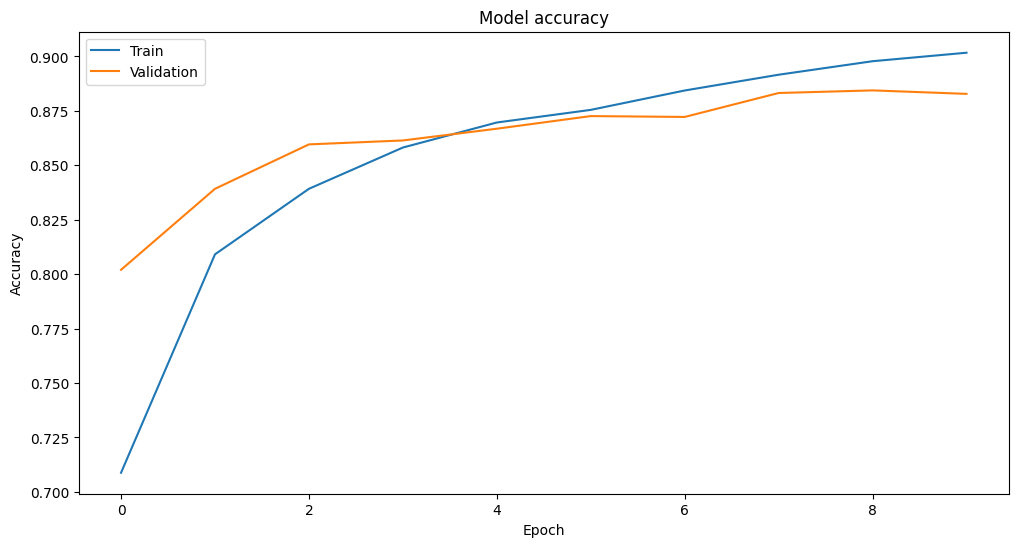

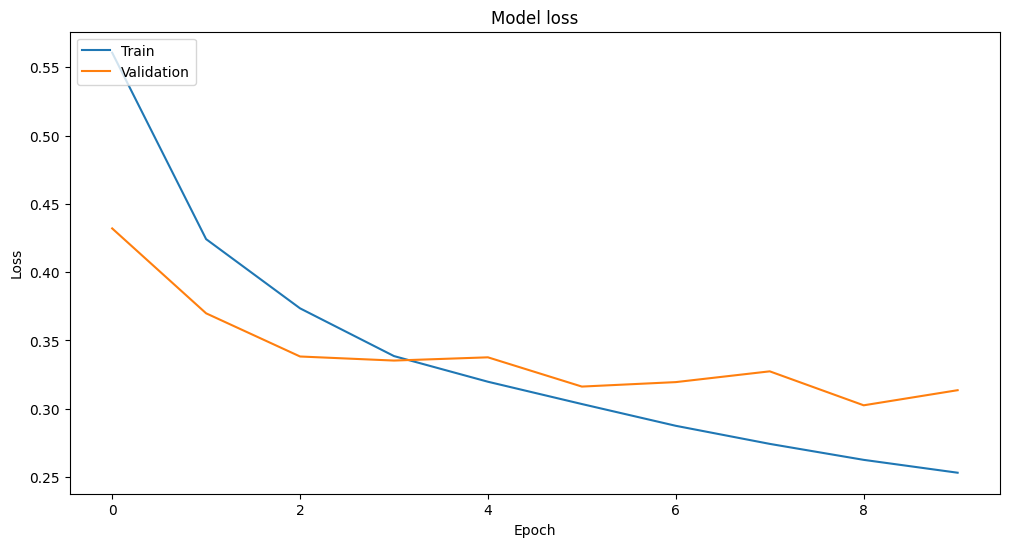

In [25]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
